# Exercise 4 [Cart-Pole Model]

In [3]:
# a few packages we need to import
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# plt.rcParams['animation.ffmpeg_path'] = 'D:/ffmpeg/bin/ffmpeg'
import matplotlib.animation as animation
import IPython

# Problem
We are interested in computing a linear optimal control law to stabilize the cart pole system when subjected to small
deviations from the rest position (when $x=0$, $v=0$, $\theta = \pi$ and $\omega = 0$)

<img src="cart_pole.png" alt="drawing" width="400"/>

The dynamic equations of the Cart-Pole model are written as
$$\begin{eqnarray} \dot{x} &=& v \\ 
\dot{v} &=& \frac{f + m_p \sin\theta (l \omega^2 + g \cos \theta)}{m_c + m_p \sin^2 \theta} \\
\dot{\theta} &=& \omega \\
\dot{\omega} &=& \frac{-f\cos\theta -m_p l \omega^2 \cos\theta\sin\theta - (m_c + m_p)g \sin\theta}{l(m_c + m_p \sin^2 \theta)}
\end{eqnarray}$$

which we discretize using a time step $\Delta t$
$$ \begin{eqnarray} 
x_{n+1} &=& x_n + \Delta t\cdot v_n \\ 
v_{n+1} &=& v_n + \Delta t \cdot \left( \frac{f_n + m_p \sin\theta_n (l \omega_n^2 + g \cos \theta_n)}{m_c + m_p \sin^2 \theta_n} \right)\\
\theta_{n+1} &=& \theta_n + \Delta t \cdot \omega_n \\
\omega_{n+1} &=& \omega_n + \Delta t \cdot \left( \frac{-f_n\cos\theta_n -m_p l \omega_n^2 \cos\theta_n\sin\theta_n - (m_c + m_p)g \sin\theta_n}{l(m_c + m_p \sin^2 \theta_n)}\right)
\end{eqnarray}$$

This is the equations we use to simulate the dynamics of the system below

## Simulation of the Cart-Pole model and display functions

In [4]:
def simulate_cart_pole(x0, K, uff, horizon_length, mp=1., mc=5., l=1., g=9.81):
    """
    This function integrates the cart-pole system (the nonlinear system) for horizon_length steps
    
    Arguments:
    x0: numpy vector, initial value for the system (4 numbers for x,v,theta,omega)
    K: a list of control gains (of length horizon_length)
    uff: a list of feedforward control inputs such that the control will be f[i]=K[i] * x[i] + uff[i]
    horizon_length: lenght of the horizon to integrate
    
    Returns:
    x a numpy array containing the integration result
    u a numpy array containing the control at each step
    """
    delta_t = 0.01
        
    x=np.empty([4, horizon_length+1])
    x[:,0] = x0
    
    u=np.empty([horizon_length])

    for i in range(horizon_length):
        u[i] = K[i].dot(x[:,i]) + uff[0,i]
        dx = np.array([x[1,i],
                      (u[i] + mp*np.sin(x[2,i])*(l*(x[3,i]**2) + g * np.cos(x[2,i])))/(mc+mp*np.sin(x[2,i])**2),
                      x[3,i],
                      (-u[i]*np.cos(x[2,i])-mp*l*(x[3,i]**2)*np.cos(x[2,i])*np.sin(x[2,i])-(mp+mc)*g*np.sin([x[2,i]]))/(l*(mc+mp*np.sin(x[2,i])**2))
                       ])
        x[:,i+1] = x[:,i] + delta_t * dx
    return x, u

In [5]:
def animate_cart_pole(x):
    """
    This function makes an animation showing the behavior of the cart-pole
    takes as input the result of a simulation
    """
    
    #subsample
    plotx = x[:,0::5]
    
    fig = matplotlib.figure.Figure(figsize=[6,2.3])
    matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-3,3], ylim=[-1.,1.3])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    cart_length = 0.5
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_back = plotx[0,i] - cart_length
        x_front = plotx[0,i] + cart_length
        y_up = cart_height
        y_down = 0.
        x_pend = plotx[0,i] + np.sin(plotx[2,i])
        y_pend = cart_height - np.cos(plotx[2,i])
        
        list_of_lines[0].set_data([x_back, x_front], [y_down, y_down])
        list_of_lines[1].set_data([x_front, x_front], [y_down, y_up])
        list_of_lines[2].set_data([x_back, x_front], [y_up, y_up])
        list_of_lines[3].set_data([x_back, x_back], [y_down, y_up])
        list_of_lines[4].set_data([plotx[0,i], x_pend], [cart_height, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=50, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [6]:
def solve_ricatti_equations(A,B,Q,R,horizon_length):
    """
    This function solves the backward Riccatti equations for regulator problems of the form
    min xQx + sum(xQx + uRu) subject to xn+1 = Axn + Bun
    
    Arguments:
    A, B, Q, R: numpy arrays defining the problem
    horizon_length: length of the horizon
    
    Returns:
    P: list of numpy arrays containing Pn from N to 0
    K: list of numpy arrays containing Kn from N-1 to 0
    """
    P = [1]*horizon_length #will contain the list of Ps from N to 0
    K = [1]*(horizon_length-1) #will contain the list of Ks from N-1 to 0

    N = horizon_length-1
    P[N] = Q
    for n in range(N-1,-1,-1):
        K[n] = -np.linalg.pinv( R+B.T.dot(P[n+1]).dot(B) ).dot(B.T.dot(P[n+1]).dot(A))
        P[n] = Q + A.T.dot(P[n+1]).dot(A) + A.T.dot(P[n+1]).dot(B).dot(K[n])
    
    return P,K

In [7]:
length = 1001;
Q = np.mat([ [10,0,0,0],[0,1,0,0],[0,0,10,0],[0,0,0,1] ])
R = 0.1

# initial conditions
x0 = np.array([0.2,0.1,np.pi-0.2,0.])

# we simulate the system
mp=1.
mc=5.
l=1.
g=9.81

A1 = np.mat([ [1,0.01,0,0],[0,1,mp*g*0.01/mc,0],[0,0,1,0.01],[0,0,(mc+mp)*g*0.01/(l*mc),1] ])
B1 = np.mat([ 0,0.01/mc,0,0.01/(l*mc) ]).T
[ P,K ] = solve_ricatti_equations(A1,B1,Q,R,length)
J0_x0 = x0.T.dot(P[0]).dot(x0)

## Example simulation
Example of a simulation of the cart-pole without any control input
here we set the control gains to be 0 and uff to be 0 as well

<IPython.core.display.Javascript object>


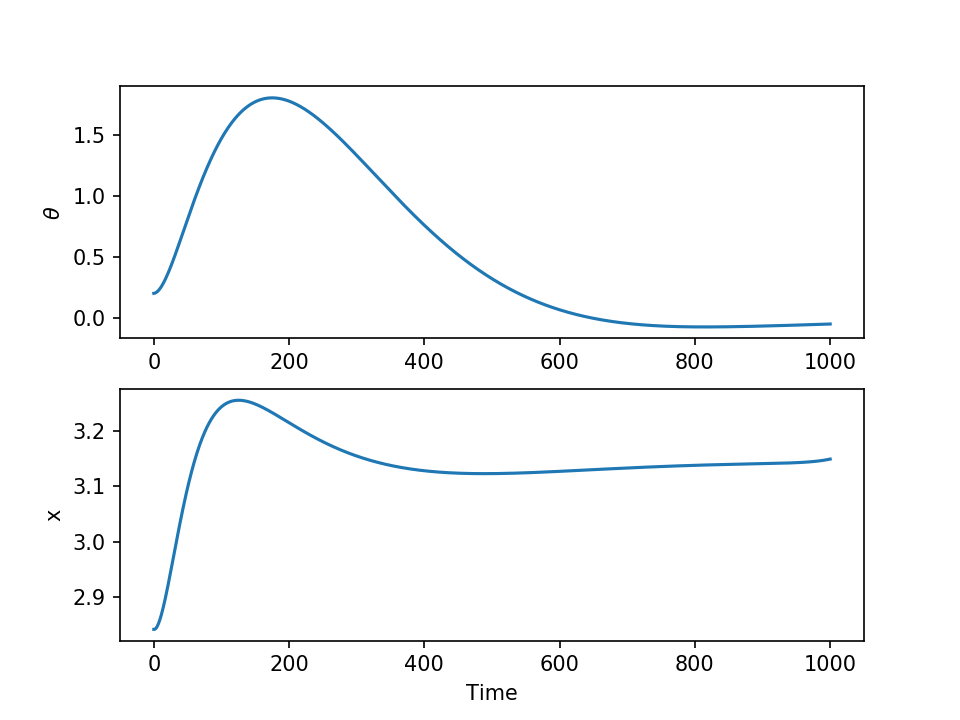

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABTHW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU3IHIyOTY5IGQ0MDk5ZGQgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAv8ZYiE
ADf//vbw/gU2O5jQlxHN6J0zH78VuLo0N73OAAADAAADAAAI0IvBoZ8PTbfzAZh90yKLsHK9k1F1
UFi8/dEAHh4AJJVsXbYGybJ9vqPNHkraKV3cGqOMtZNfXmX7eQF+Zf5L5v9wnBmejHNZbiSHWU02
RPRMEr/D6dX9FjrgTsVkqoMc7RKOyD8FNryLTwRJ6WpF8slq0KNGQUkNpPFxg/X5xfqlBktYC2Bx
ZYVTNwO6CgGlYi5F9BZN8NSJbB5KbZ7xn5dGpdAqO2l6d/yNTPF4qBM/mmiumvnsWUkvXDfhuKfg
UKwccDVmihJfXQgW/6PGAQHvJd9IMeEAWQ7O+RxuFcEoxfkZjAvjmJgYNHBjj0lEseSyIVdFc5tD
0EHfb6iuYtiVbfGpDsKV67C5IJnJpFxAjbUadFaEHwJfy+conPrYdFqfjiBtk7jEaK6W5vUbF1Hk
a/zF+rI7U+WrnQC9KmJsxJevBuOcJYUQPmO+70EobOy0KmTBiqTPKe/iOLlDdl2hwHKRrIn4C41b
Of5OW/wx+a072KYdXq6+/cb/f/QFf7edRlcMcq77dzjFSRxUnhvS3A+qtlN+8wVReyeqQp6yVCow
4GwSp5vK0ccoPktzG02GQzK3LccOvsz8IK6dV4x9Gy++46lddUWHvo+/pM573VAmO3chYpxYyGd/
lHhBb5N/ov1YEiiVGx1x/JTtbgANU9gnmYikrjFJ4vZuGqW/5Wm2cPiykgSbqQT1o3YDkjKOHuJb
JtqIPMGR8Hu88CwlxE31+lKLAPHLcJQZCJsdoCoPqsoQwO/FEhgsdkCr5bU+xWZ39TlSHFY1LmBn
utbO8cM1NCQCb9jSX2EsfubJKNtM264/pxL1ah2nF75hj4B9v3EBP+gChpe6N40TPDKvzsgPaRYY
FKNJ02LkCO/Wc1RJxaSVI2OJcf0Qi+bD1M/5aiVyJH+SEQi2v1Ig1x1gMuY1cK6irZLf2Saw8mhk
xzAgRMWlu0Z7jEJ9UomHV0H/NzLI7wqYq3n9Ppc0O5+ixwepoN5xj/k5mW6wXohbxn876RYG2nwp
dAN+b/Ej/JsDIVr+7Trk4e+aZv65oRZqkTqNure6j/ZQ8C+HSvP1UtW9bd81GX++h3TMTRuKfcM5
vTAx3Jfb/8KovC2XvN0O/1+hPI7p2X7QnS3dVJmmvU6Tpy86kTbvIhZjQKyrvIlPvgBXztd1/kcO
zdD+zyMoUS6F2cO7PQEMwTkreZqY/zf/QmagMEsiAxBK+LY4e35uU+zDusg0KeN7dRSkfGrzb5g+
3HhZTEjndwrDV2g213uAXSPionadWFrUPyej5fr2HxsP++xeteQ533nBhkaYt5ntN0YXzDRAMZXf
6ezVGxdUGyxT1EIxU+UUyOOGxXO7esUJdrOp1pcWG/HmbyoqgAAETU073fO+xlKib3OjXquyFRZm
J/YPFIGw+nXdJvkvyo0tyqSR7P9CPxiTzm3NommaGUFzdfXWLmA8UIUBC2ZvH+nbdvlhoP5tm96d
6HrC7gb4mB3t0UFQpaiRI0HDJ10QCPkRXhPfzdpuMt1LKR8k4jGF9KSOFZzEqE1+u0RNQjYu7UL0
IRWopHGolp5rOtVYZZgeNjGKQlDJ2b5N3a28Q5Estb+6EKYKspROp77LoW0WDRpcupCnr+Ii7oTj
FlwvW1BYyDmvHXr7ZTf2T7F43YofUIO/a2pq/ER6z27CI43nuxHDcxLSd4uFPiXGYC5eEHVGE1/o
ACXDz6ACcsE7EVgRm2US6WB+1ZWTpM9rqrB53S+X0dulQx6JDc4LfdpzMU0rOzOJp/SHZfZ+Yi65
rnq4eXwj5ZQmri9Y4+ZZUMCgrgvQf/byhbzcXCXjddQ7XZBhv0atYgXHGK9MqJhyq2mI/pRG4SeR
40K6j/H8Nn6b95YcYmMshyS0WENl6Z3XAcUbCaKVyh7KX9cCNfZ5maKVe7h/HCaEEmeHHApdECYM
WCPCsJy5DhE6Wa1fmdFa1AApeTBQJnnybt8iuDVOfYY2h36hAXCK63xsQLBtQHzjJaG9IuOp3Y3i
vMgwaX4gJQ62XL2wA/gUAV4C8NRF5+7EYgxgn2eUqABgg92HdMgYlDflqkKRMrWpjQDK4apG42hi
WaM3omr1HFb49cTSimfNWIHNA5+o8p9egEQ22+W7ZaG9k7DqJ1C9OAMGDLiwAHSrSV0gfpFfuhSD
I9LV3JxGrVSBM/J4wnom6KdCj382o0dmqGN5Khc4PD37a/civl67r6dk4IXIZTS8mXIXmChvz0XS
LoBezpx51LlR4IAjA0jPAZmQ5cRmB1meSqOwcdcyPW7TP455WX+1QSOUJ6ePUhYIq4mqzXWI21lK
/RL8Ia2aCd8hwHbdim3uCUVI853ZKNU3SSHee2xXmkPFJwXrcMEjrku3CkvUCnATqlrxkR1IBm5O
Z23meW+c1OduFn/b6YOeO0r9MZEU3eqYAfalr1M38DSvWsd0hAomqEO71NOWZAIW2Hd24GaOVQtE
wK82p6nx5Mp2uD+A02a2foAMDrp76nYC0AiwWCPvgutyluN0zROb13zhYan2uz5Ut7Z7xN6TSCn3
aVOSe6ILtfQjEmJ6WSMFFrxtq2DcGc6e2zhehMdBsknqp6fD3QWEE8xjpiMlh373ewKW9rsgxxwD
82tpLmNYZZACSt5Gt7IKKTNCiQAo2Ffi4ckOgEJfIqRD+z4OYjPMDLtryzQe6Zgvnj1rH8mX2i86
meXBWTW3nB09mMH9WVISDvxrnrxBW1uXYmuV6jTp7lIuRPjpGIRnXv0VMjWEQ+4DOY5fujdR11kI
Ppzb2HBMaeKOLg3RVi00l62PTT+UgXUJI/RFR8gd0QmzLheSV3tRhdi1emEHOrZgFTlWjliFT+0Q
hG0c2qC4GKx/iYjoP72i8

In [12]:
horizon_length = 1000 #this will simulate 10 seconds (since deltat = 0.01)

# here we set gains to 0
# K = [0,0.,0,0]
# K = K*horizon_length
uff = np.mat([[0], [0], [-np.pi], [0]])
uff = K * uff


# initial conditions
x0 = np.array([0.2,0.1,np.pi-0.3,0.])

# we simulate the system
mp=1.
mc=5.
l=1.
g=9.81
x,u = simulate_cart_pole(x0, K, uff, horizon_length, mp=1., mc=5., l=1., g=9.81)

# plot x and theta as a function of time
plt.figure()
plt.subplot(2,1,1)
plt.plot(x[0,:])
plt.ylabel(r'$\theta$')
plt.subplot(2,1,2)
plt.plot(x[2,:])
plt.ylabel('x')
plt.xlabel('Time')

# make an animation of the cart-pole
animate_cart_pole(x)

# Question 1
Linearize the discretized equations of the Cart-Pole Model around the resting position $\bar{x}=0$, $\bar{v}=0$, $\bar{\theta}=\pi$ and $\bar{\omega}=0$, $\bar{f}=0$ and write the dynamic equations in the form 

$$ \begin{bmatrix} \tilde{x}_{n+1} \\ \tilde{v}_{n+1} \\ \tilde{\theta}_{n+1} \\ \tilde{\omega}_{n+1} \end{bmatrix} = A \begin{bmatrix} \tilde{x}_{n} \\ \tilde{v}_{n} \\ \tilde{\theta}_{n} \\ \tilde{\omega}_{n} \end{bmatrix} + B \tilde{f}_n$$

where $A$ and $B$ are matrices of appropriate size and $\tilde{x}_n = x_n - \bar{x}$, $\tilde{v}_n = v_n - \bar{v}$, $\tilde{\theta}_n = \theta_n - \bar{\theta}$, $\tilde{\omega}_n = \omega_n - \bar{\omega}$ and $\tilde{f}_n = f_n - \bar{f}$. Remember that the resting position is a fixed point, i.e.

$$ \begin{bmatrix} \bar{x} \\ \bar{v} \\ \bar{\theta} \\ \bar{\omega} \end{bmatrix} = f(\bar{x}, \bar{v}, \bar{\theta}, \bar{\omega},  \bar{f})$$
where $f$ is the discretized dynamic equation of the Cart-Pole Model

# Question 2
We would like to use the linearized equation to compute an optimal controller that stabilizes the system around the resting position. 
1. Write a cost function that will help stabilize the resting position (be precise with the variables you use).
2. How would you (approximately) solve this optimal control problem?
3. What will be the form of the optimal controller $f_n$ (remember that the linearized system will give you $\tilde{f}_n$)?

# Question 3
1. Write a function (e.g. take example from Exercise 3) that computes the optimal control for the linearized problem. 2. Simulate the dynamics of the Cart-Pole Model with the computed controller for initial conditions $x=0.2$, $v=0.1$, $\theta=\pi-0.2$ and $\omega=0$. What happens? (show a plot of the states of the system and the cart-pole animation)
3. How can you change the response of the  system (how fast it stabilizes)? Give an example with a simulation.
4. Does the controller still work when $x=0.2$, $v=0.1$, $\theta=0.2$ and $\omega=0$? Why? (show a plot of the states of the system and the cart-pole animation, use a smaller horizon if necessary)

<IPython.core.display.Javascript object>


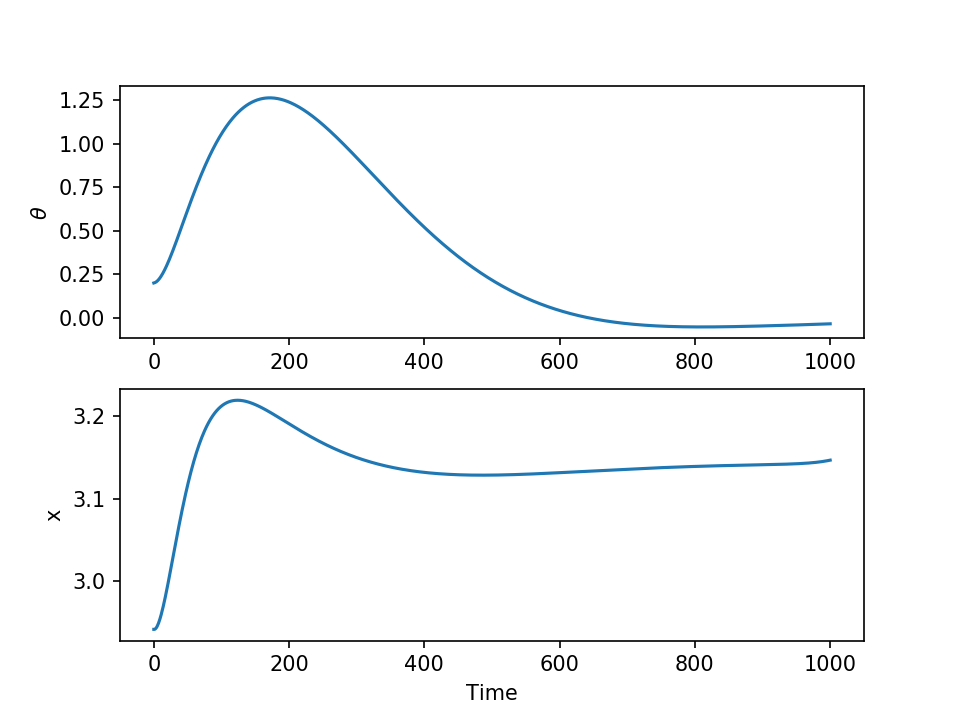

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABSLG1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU3IHIyOTY5IGQ0MDk5ZGQgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAvmZYiE
ADf//vbw/gU2O5jQlxHN6J0zH78VuLo0N73OAAADAAADAAAI0IvBoZ8PTbfzAZh90yKLsHK9k1F1
UFi8/dEAHh4AJJVsXbYGybJ9vqPNHkraKV3cGqOMtZNfXmX7eQF+Zf5L5v9wnBmejHNZbiSHWU1A
E9NNAfS34VeQI3tn9MEaQOTow69yEritgT0Af2pik7Ym/76fYYXxKa/8cfwdA8cZw1xyehM0WFjZ
beEpWiaFwHiIs5wea57hP4qWWLwpwnpDKOSjAO6EJELlaM7gA584T0+XECLQGC+dAMr14V8oMMU0
uxYo+S8YIhRCHOO9mkbjnpvqDfhuPwlQWgDfXBI+OOv+eKUWEOZRHR1sXNWBwOrslr/EaxQmG+Hl
2SiwkiKIhBE+EqB+lEf7QQKw1qYsrGf5lsQngyA4lW3QS7nQdU8IbUwePaTmqrZL+XWS6rBhfxth
y2fhjS8MSdL7ybeET0jm0anmKmgspTKV6luCEodgPsECS6122Pou+gO1exh22BqBgD4qCHpGdJsd
Fae2qha07NCX8ll7LrJAQBmniWVn60v+X+S+aYVbaEcyC6dt7PD3G+yv2ts84krEyHuCF3R3N5Sa
IRv8ccRUB9VbNL85EmEiO6JCnMiEXEB1RglTzeVo456/Iig1ghJR28d+PpFfaP4QV06r6636pXWw
Em45O5/qsu1YEy8qoQsN4ph9aYbmvHXJpVFDBFYTPs2PFZAHYSijVMuyHjifzhCiDOAgCdeqgem6
ZX14k5DDg/R2XLVz22MIzdH6BOxvwbghjMbyPl0Tjn0+ZEWCw5VP0wZY545ARq/3PRh4vvfmHEzA
ABJLNA7S+SnjKaP0xmVuzg2c4k0TENT7Q/2Q/MHef5SRUo9byLmiA5lGT32G8OU04Ju+klI+wECd
gwCgJ1DdkEkw6PkGuJvDs6JuPLYPFahLFpybxA3KmRdm3309p8m5oeJG33H9h5mTyY1cgMzYycjR
NDNfonyVhz9wFryINEe9am6wJCph6qt5/TRt8ncsZrgRvWsrYR3V0tdMzP8OHDZaHFqt6X+iCnDn
EG6mDP66wMhWv7tOkBmTW4zodqCCzVIBp/MjtnPzKWrBgwHqJ7RKJXnc0O6wJx3e6ahXvbYmJDeS
HlR+vZv/DVg5o5E5AZ2tjnCPJnjBSK+A/yu8U6Tp6cYpizJVwswsKSFhguvaWYpAMkd3kcOzeJ/k
aQg4jHyT7rewiLfMRM9z81Mf5v/lv6QaGXk5033jzWZE/m9e8Mde6C7YNUVhky9YSE216ymrtoZc
VLsXBiy42k/FEop2yZ1lSkJc/i8Rd5g2twQ8UieEzQkEevK6UipcRp5yhxGNA0uPNl9rA45j8AR+
7bH2hgc/b/T1ATuN+Xo2NOlZWv0El7EqkXtGnqgVklLd1sb1ur5Vj7QbsxkZNvCTm0gqdGiANwaB
I+5mWdu8vY1LIMvZA6NjO39PsKi+XdGvjKYMmqMz8PTNoPiS4bl1lAOVYf7UlG0rIFujzsWo6o3V
4PdkknIwYbnwxM9LOBlTDSFaybv47a4Gw/4n57nnZeBi1cgxZn1sLMYQErQuSMcUf60J3CaXbkXg
qdM3DAh3Q177iakDAGAx0MJ7sE+tvTewUrN4uLgN0CvFxuriN4lzu/s9SDuARXm69HmAK3pMlu9X
EQa5LeXmEnUkRHCqim8+EK8GcOjqMuE9Dbt/qbzP6jSartaYYs1SWFqFEAU1poEd09en/EI8hQFY
AB+hyvycxyFP9P/e3ukzeknfd5bH74GrUWtaWUmlyImH+fjvmQCa/+2AzvEvaewkCjLpwIEZYBBW
OrFN0SN4U0kltXV4D/agfn5l+IF1HOm9sLe7Md1STkRcebYfwIjU3wHwaWxNKcvDF0IXEwvfba9y
G2aEISNf3by+6N3AJ7AhbtH7PVXK0q+Xv/BayJytp1FcMfWsEXfDSeKKScTTrUweb4W/rFvIZQAY
mPFWCLmKvT85U5U/0sluu9SjMcINuFO1NSxcxjpza7crovMhhwJdm/5/zIP2Va8jiLOFeAvDURef
uxGzbfG06b1wAT4Xdh3TFygURjENkw98AQ21gCh6mG+5HvUH3Ti+EwitgzXQ7yoXbS72Qr0kyB7k
qcjdstDeVkUEQo3dHZpjxf5eshxhY0i52fxnxZKqnm/JZsSz8unM5JCKa3dkqYHirE36/LnF8cgR
o3ElOeGpJIl2Cs3QQ4R4IZxvoBwL5rsurXvNZAAbdnnuFck6iy6EI2peMFJOeK70Z3fwgIUhx606
1Wb6wlZZcT23xOlzr2lf05tdr8RBBatD3Z4adIeVAMFEvPw5fhDWzQ7cKObZY9UlGbj10hnO7JRq
kVuXqkWHQ07PQrzrcMEjhYMyUO6xmL83m/xOZQiLI0OVrQXgi2tzU524Wf9vteJX1dLmuTQeXFoB
VSyc5qlFyb2NgpXsGwY0BDvANSkmQCFth3duBmjlbZ7mCvNqewswQ0ydr9od7J8mZBlnA8s0nnQD
qaRAH/zU9jlI5FjRtgtGzSyICM1Zq/YEc8nFBvu2WF8+Vpjk1Xd8OUy2LeTPgoyw/D367cxSoEQw
/YPPmP9c6pL0+7oLFhKJHUuQ9tp6E3ykM9VH887di2RIigzi9Z2Np9/w7eD3/zZMHMgpo9DOwfzL
QYWk5w/5zBMRi85M0gCifhxqAxhXL61M/vAUemx1eiBSBE2uez9qR+oMyeWAWv8FVNPeJRviNwdA
5QyPkxBaWl4bHBvKkZzaSlQ78GusB1WXkcnkDDh3CtYzgfMZV6WdklaRV7LgfTm3sOCZfximgN4O
sUuIPdxpp/KQLqFUKnycZkO6ITZkLXwkiAJhdi1emdDAgO6uxRuGLFD7mKrhG0c2qC4GNMJq0MI4
x3U+6Uv8+oFcidtuZyF9U

In [9]:
######## Question 3(2) change R to 1, response is slower.##########

length = 1001;
Q = np.mat([ [10,0,0,0],[0,1,0,0],[0,0,10,0],[0,0,0,1] ])
R = 1
# x0 = np.mat([0,0,0,0]).T

# initial conditions
x0 = np.array([0.2,0.1,np.pi-0.2,0.])

# we simulate the system
mp=1.
mc=5.
l=1.
g=9.81

A1 = np.mat([ [1,0.01,0,0],[0,1,mp*g*0.01/mc,0],[0,0,1,0.01],[0,0,(mc+mp)*g*0.01/(l*mc),1] ])
B1 = np.mat([ 0,0.01/mc,0,0.01/(l*mc) ]).T
[ P,K ] = solve_ricatti_equations(A1,B1,Q,R,length)
J0_x0 = x0.T.dot(P[0]).dot(x0)


horizon_length = 1000 #this will simulate 10 seconds (since deltat = 0.01)

# here we set gains to 0
# K = [0,0.,0,0]
# K = K*horizon_length
uff = np.mat([[0], [0], [-np.pi], [0]])
uff = K * uff


# we simulate the system
mp=1.
mc=5.
l=1.
g=9.81
x,u = simulate_cart_pole(x0, K, uff, horizon_length, mp=1., mc=5., l=1., g=9.81)

# plot x and theta as a function of time
plt.figure()
plt.subplot(2,1,1)
plt.plot(x[0,:])
plt.ylabel(r'$\theta$')
plt.subplot(2,1,2)
plt.plot(x[2,:])
plt.ylabel('x')
plt.xlabel('Time')

# make an animation of the cart-pole
animate_cart_pole(x)

D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in double_scalars
D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in double_scalars
D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sin
D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in cos
D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in cos
D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sin


<IPython.core.display.Javascript object>


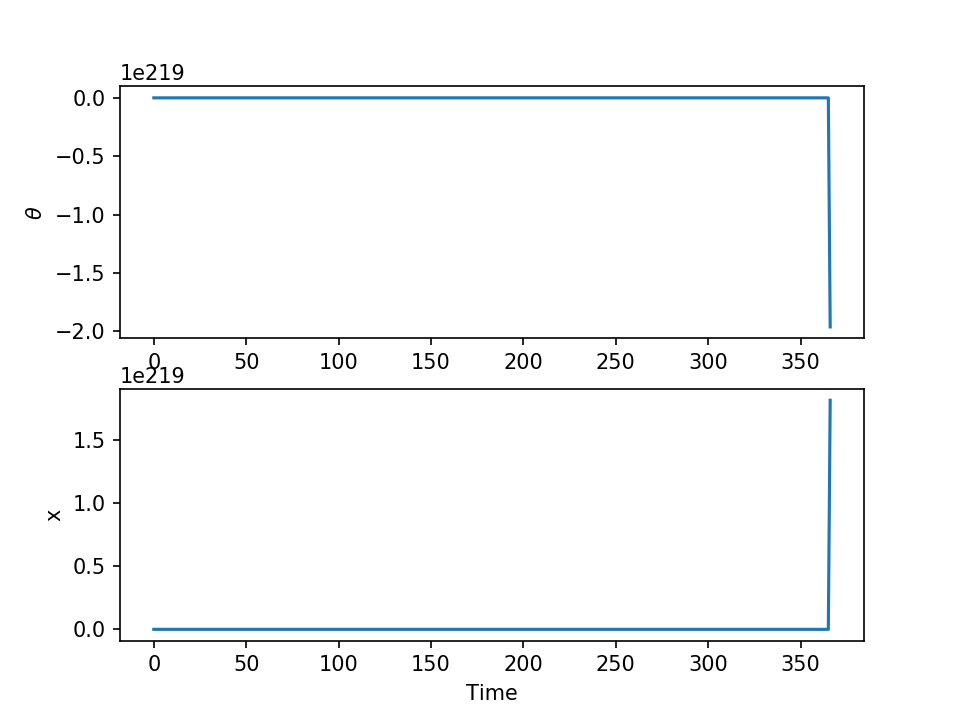

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAjd21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU3IHIyOTY5IGQ0MDk5ZGQgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAuPZYiE
ADf//vbw/gU2O5jQlxHN6J0zH78VuLo0N73OAAADAAADAAAI0IvBoZ8PTbfzAZh90yKLsHK9k1F1
UFi8/dEAHh4AJJVsXbYGybJ9vqPNGQ18jmmGZuCfafb6WkbIKzAe+2D2q3l2Bm2bviKSlIwoeU4B
gAam3woeZaVBm80tzRH4jzzTZus/0v2wQM+md8cndPD0s4MnTa0tzi0Ra2qh+6vJIRVZ07PUD/Oh
XYzwMcEyw+yxz5wnp8w80weDIk6AZXrwr5QHIO4ySO/vl4wRCiJK0p5Brb819m5YV+zmv1efSLGC
mzaogUHjN1E93OXKpqgUSxx0KpDwvBvdk3YsHZslNg5TAA2BmheOia0X1AHBM4HnYTbYc8Pcg+xp
NJBxiScO7afcirbWpdovf2r2Mca1SMkIHyzXjx5RInHrbVUeFawkcXVxUXE5erbkbBE2HiXaX/L/
JfMYbg3vVimHV6uvv3HE3P12YoSJ6B4zqbUqmJVjxB7eV8muVaK5CMyH7VXW+TOnNbzpf4FbA4Xb
a2bEwNToFM1Y3Z8TUspTPVR4uEUrxFSaW7OFPZc1D9v462BR96X5xY1jlgYEA+m+oE4EQEJHkj3Q
s2zRjv0Q8G5bByt3t8t0PQXbDIY0AHmeZHD+kL4t4+jVAf+r6oT/3YghPm1vYWMF0OuDhwoRfZmh
VH+0w9tEMblmLTai0MV93rhf80O9wcDA7LKQbP+HiNSxGkpyNE0M1xoiQi8zTk9nwmHVwlzHkrI7
wqYq3n9O58e2PG5wNkIyLD++KheQylJQCS4OhA01rlGQu+H6xq6iye8FkHHZzDN+a7x0ZJ4x0O1B
BZqkPEmWztnPzKWqay6NdCwYdizMLTD/hOO73VOmq5/7hnN6YGO5LXP/ZMZzTHJDeJw/gejQG3dF
laxpn7iaV3vVwxtUo+3rrSdeTpmHrEE9KsL/dVwpUK+XnI9L0V48BkiluBeQfhqnQAR2SePEiAP7
qci+WRQYjYrUzykxw20/C5hJcN5ThRzwgfyWmf7tuJbyphs/fUBXxmLgkAAWI/7NJsjGLmeRO2Id
/L0TReckSXigFymYs1mmUv0uR7Be+9/rtj8IQ01DtXkR2GKQRIh0//ermvCF+eE9Yb5E6bp3N4ou
tj9k9JXvZA6YKRgZU2po56jsChEbTfLduDQcLeZWFDMtLw+YGrY257biSW8rQ2X9aMeqO6sMY+54
Ae/1DwvD9b+Qvm+pdRBuxK+YZIqphdz0ja77fiyjZdMDVPtg3/M75JIjKMRvdh06PHYFksucczwW
afxcKfEuMwGZgjDbsHqbzP5gmRWTLQLSVInyoUQBTWhJehRWUByEeQoCr+yfjyPPXddVHCUJ5Kk7
8eE1ASmaJe/pjj2yRQPJfB/SMbefO2sL8jQWe/LIMtipNwKNDZ/10ognxBfcmsxCn3VwKaPrqI/O
bxpB/ZJOLckb3uJLKkfwALcT34jCBNvFc5fEf3iqY9h4dUOEryn3wGmFxv5l2XZw72ZeKcLh4LoD
P7u4X+n04x4g9ySPomEFt3dLdIXLRFmZSy/9UaoUvtcl3OxtNpH0/UpemaAe/wjuAqj6WBBvssAA
0MRXKFkiZ17AVSjpnYlzRPmep3U9UwwnN3GNkJCemWZH2V7m5+bCkUxAYASeIVRyNGncSRXTlFcd
gqIDXlJN6Bbj8/0B8kjJb/ACff7YBTCaMbscM7k32RYwO6NpmPjKI1qsENu0VOgJc3rYtRruWVoi
vcicYCW0pp51+uX4aXFSgAF70aMUrxBZdTnEpECE/Bw/JWXiOdVjjhFYnNwq5YSUWZ9w0+VXp4TQ
7Bp4vc9+f6+JQcrrzGXfSgCnhVt95S9KwEcsOkqyyfbSpdrlVMlK1lJuemdnjFvq4QFUwl92PEmK
4CO9GhUjIeibdFklhg86nTB2507wuQWm2uzQqA7A+W/C8vg4r5m4Q+T9LxOXwvG6U5tzSy+ixP3G
+b9ZfYt2sX9eNO7lqOpFUrjnhPQ7vphTkAu+SlJtoxNjxrcEozGBmmnHjMy9B6juV+7uvglQOudp
FvS0txkZx5Tv1PVoCJOEQhRIOnXVc+lcaHa2dvgFMow/x+9NSXW0a33lDsxelHI3eHJoZZP21/GO
th4vCWsU8sQk5GHK1oCUfNizZd/mPKOSGXkhqcv6YyIpu9K8gK7fom4/yWP8wzVxhAomqEO8Am57
e10LbDu7cDNKBxxR2PKiaEtxDzucszjgNNmtn6ACyyOw9/8WwKWRWuz74Lriiw90wmRS7Ou+cLDU
/gZvsruOT5dPH0j2fRw5wzkiUF2voRjJXPNXI66nOcglINwZzp7bPEU8hg6P4RC7oLCCeYx0vPT3
NtlyFaLwCBcFn/vnz93hG+Q3cRkZRoHymbc3K9dDxlrUIWVXOBaMkeHmZ9tP4U+NKwU7B3KJVkAp
cl7/ONamO9N4JMcNQBZDwNDzfTAV4XtE0pzNQGJA/1Gq8kqtFJf/3kEvg6vBeqMT07gsNALnF3ex
b6dgAAM8qyW/zWLidEjoHlabT23JIY53swV/lQ33Nlq6cPSkg2aAGcgeNc9zbW+cVgnS8AGwk/pV
vcaZSPEbgVmbqpmA+68eDYIdztI7xvU2s1gnGs9WhRkk02zAFxfU38Rzh/dsaLev+piji4N1msjb
0P94SNmT4o/J/TYiLkH6EEkCqvJkjmVR0W8pqcOGWHBbIXYo3DFihwLhGarU8f/raGjcTqE6sIAt
Qk896+9YzaObO5HdkEMqUSTyJv+0w/65DeeV6gvx3hYSACfOxZF/qO4QMVzdK62FJW/AKr7Bgc5S
yHYEGFXnCQP7zhFb3KfP7e7l+ny4T+0/EmlAOsyAaTNvtNDtSR113t58jBbVZVpFgdoXBggtpGuq
KVFclrv5LI5pisFrJirO2

In [10]:
######## Question 3(3) when  𝑥=0.2 ,  𝑣=0.1 ,  𝜃=0.2  and  𝜔=0##########
#################### Can't work !!!!! ##################

length = 1001;
Q = np.mat([ [10,0,0,0],[0,1,0,0],[0,0,10,0],[0,0,0,1] ])
R = 1
# x0 = np.mat([0,0,0,0]).T

# initial conditions
x0 = np.array([0.2,0.1,0.2,0.])

# we simulate the system
mp=1.
mc=5.
l=1.
g=9.81

A1 = np.mat([ [1,0.01,0,0],[0,1,mp*g*0.01/mc,0],[0,0,1,0.01],[0,0,(mc+mp)*g*0.01/(l*mc),1] ])
B1 = np.mat([ 0,0.01/mc,0,0.01/(l*mc) ]).T
[ P,K ] = solve_ricatti_equations(A1,B1,Q,R,length)
J0_x0 = x0.T.dot(P[0]).dot(x0)

horizon_length = 1000 #this will simulate 10 seconds (since deltat = 0.01)

# here we set gains to 0
# K = [0,0.,0,0]
# K = K*horizon_length
uff = np.mat([[0], [0], [-3.1415926], [0]])
uff = K * uff

# we simulate the system
mp=1.
mc=5.
l=1.
g=9.81
x,u = simulate_cart_pole(x0, K, uff, horizon_length, mp=1., mc=5., l=1., g=9.81)

# plot x and theta as a function of time
plt.figure()
plt.subplot(2,1,1)
plt.plot(x[0,:])
plt.ylabel(r'$\theta$')
plt.subplot(2,1,2)
plt.plot(x[2,:])
plt.ylabel('x')
plt.xlabel('Time')

# make an animation of the cart-pole
animate_cart_pole(x)